# About this notebook

In this notebook we analyze how Prophet creates predictions. 
We start from training Prophet model on synthetic data and then we go step-by-step through prediction process.


# Import packages

In [1]:
import pandas as pd
import numpy as np
import math
import time
from tqdm import tqdm
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

from sklearn.metrics import mean_absolute_error

np.random.seed(123)

# Synthetic data generation

In [2]:
def linear_trend(t, k=1):
    """
    linear_trend = k*t
    """
    return k*t.reshape(-1,1)

def cyclical_component_1(t):
    """
    cyclical_component_1 = t * sin(t) + 200 + NormalNoise(0, t/3)  
    """
    noise = t/3 * np.random.randn(t.shape[0])
    f = lambda t: t * np.sin(t) + 200
    vfunc = np.vectorize(f)
    f_time = vfunc(t)
    return (f_time+noise).reshape(-1,1)

def cyclical_component_2(t, period):
    """
    cyclical_component_2 = 100 * sin(t // period) + 2*t
    """
    f = lambda t: 100 * np.sin(t // period) + 100 + 2*t
    vfunc = np.vectorize(f)
    f_time = vfunc(t)
    return f_time.reshape(-1,1)

def target_ts(features):
    """
    target_ts = averaged sum of features
    
    returns: y = 1/n * Sum  exogenous_i
    """
    a = (np.ones(features.shape[1])/features.shape[1]).reshape(-1,1)
    y = features @ a
    return y

In [3]:
t = np.arange(0, 200)
exog = pd.DataFrame(
    np.concatenate([linear_trend(t, 0.3), cyclical_component_1(t), cyclical_component_2(t, period=2)], axis = 1),
    columns=['linear_trend', 'cyclical_component_1', 'cyclical_component_2'])

y = pd.DataFrame(target_ts(exog.values), columns=['y'])

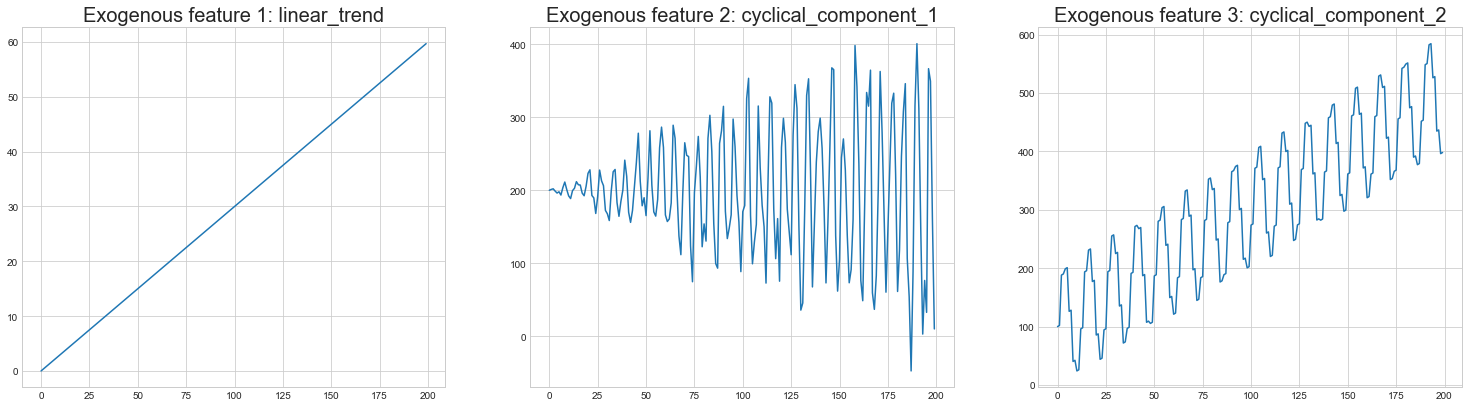

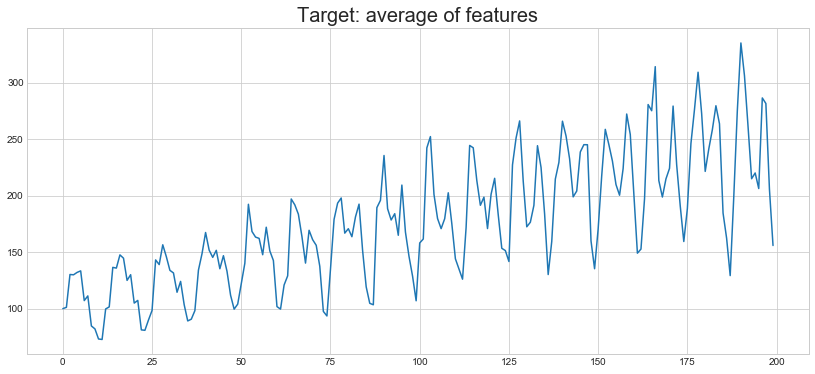

In [4]:
fig, ((ax1, ax2, ax3,)) = plt.subplots(1, 3, figsize=(10, 5))
fig.subplots_adjust(top=2, bottom=1, right=2, left=0, wspace=0.2)

ax1.plot(t, exog['linear_trend'])
ax1.set_title("Exogenous feature 1: linear_trend", fontsize=20)

ax2.plot(t, exog['cyclical_component_1'])
ax2.set_title('Exogenous feature 2: cyclical_component_1', fontsize=20)

ax3.plot(t, exog['cyclical_component_2'])
ax3.set_title('Exogenous feature 3: cyclical_component_2', fontsize=20)
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(t, y['y'])
plt.title('Target: average of features', fontsize=20)
plt.show()

# Data preprocessing for Prophet

Prophet requires data with specific format. The input to Prophet is always a dataframe with two columns: ds and y.
- The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp
- The y column must be numeric, and represents the measurement we wish to forecast.

In [5]:
y["ds"] = pd.date_range(start='1/1/2018', periods=len(y), freq='M')

In [6]:
y.head()

,y,ds
0,100.000000,2018-01-31
1,101.157973,2018-02-28
2,130.251449,2018-03-31
3,129.988055,2018-04-30
4,132.110355,2018-05-31


**Prepare dataframe of exogenous regressors with the same dates**

In [7]:
exog["ds"] = pd.date_range(start='1/1/2018', periods=len(exog), freq='M')

In [8]:
exog.head()

,linear_trend,cyclical_component_1,cyclical_component_2,ds
0,0.0,200.000000,100.000000,2018-01-31
1,0.3,201.173919,102.000000,2018-02-28
2,0.6,202.007247,188.147098,2018-03-31
3,0.9,198.917065,190.147098,2018-04-30
4,1.2,196.201323,198.929743,2018-05-31


# Train-test split

In [9]:
N = 100

y_train = y.iloc[:N]
y_test = y.iloc[N:]

exog_train = exog.iloc[:N]
exog_test = exog.iloc[N:]

**Remove target variable from the test dataset**

In [10]:
del y_test["y"]

# What is the Prophet model?

<img src="pngs/final_formula_new.png" width="100%">

Prophet model has 5 training parameters: 
- $k$ - base trend, 
- $m$ - offset parameter, 
- $\delta = \{\delta_i\}_{i = 0}^{\#changepoints}$ - changing of trend in changepoints, 
- $\beta = \{ \beta_i\}_{i = 0}^{Z}$ - parameters for Fourier series (seasonal component) and extra regressors (exogenous features), where $Z = 2 * \sum_{i: \text{seasonal-features}}\left(\text{Seasonal-order}(i) \right)+ \# \{\text{exogenous regressors}\}$, 
- $\sigma$ - level of noise,
- $mu_{\text{train}}$, $std_{\text{train}}$ - mean and std value, calculated for each the $i$-th regressor on train. 

Formula above doesn't take into account some detailes, for example that time is standartized.



<img src="pngs/stan.png" width="100%">

Where by $s_m$ and $s_a$ we denote coefficients (fourier coefficients and standartized regressor values) for multiplicative and additive terms respectively.

<img src="pngs/changepoints_process.png" width="100%">
This image was taken from original Facebook Prophet documentation, see https://facebook.github.io/prophet/docs/trend_changepoints.html

<img src="pngs/changepoints_prior_scale.png" width="100%">
This image was taken from original Facebook Prophet documentation, see https://facebook.github.io/prophet/docs/trend_changepoints.html

Parameter **changepoint_prior_scale** affects only in MCMC mode. 
Changepoint_prior_scale is used as initial parameter $\tau$ for prior for $delta$  ~ $Laplace(0, \tau)$. Stan optimization uses priors for optimization procedure, that obtains estimation on parameters. 

In the case when we set changepoint_prior_scale is equal to 0.5, we have more flexibility for prior for $\delta$ in opposite to changepoint_prior_scale=0.001 . And this will influence on estimation of this parameter. This effect we see on the plot.

# Example of Prophet model with two exogenous features and two seasonal components

Let's make a Prophet model in which we will make a prediction for the first three points from the test data. 
1. We consider **two multiplicative seasonal components** (yearly, montly) with fourier order is equal to one
2. We add **two exogenous regressors** (out of three that were used to create target (y) time-series): one with multiplicative mode, another one with additive mode.

In [11]:
y_train.head()

,y,ds
0,100.000000,2018-01-31
1,101.157973,2018-02-28
2,130.251449,2018-03-31
3,129.988055,2018-04-30
4,132.110355,2018-05-31


In [12]:
exog_train.head()

,linear_trend,cyclical_component_1,cyclical_component_2,ds
0,0.0,200.000000,100.000000,2018-01-31
1,0.3,201.173919,102.000000,2018-02-28
2,0.6,202.007247,188.147098,2018-03-31
3,0.9,198.917065,190.147098,2018-04-30
4,1.2,196.201323,198.929743,2018-05-31


**Create train and test datasets with two exogenous regressors**

In [13]:
data_train_joined_2_regressor = pd.merge(y_train, exog_train[['linear_trend', 'cyclical_component_1', 'ds']], on = "ds")
data_test_joined_2_regressor = pd.merge(y_test, exog_test[['linear_trend', 'cyclical_component_1', 'ds']], on = "ds")

# Take first 3 points for prediction
data_test_joined_2_regressor = data_test_joined_2_regressor[:10].copy()

print('Train shape: {0}'.format(data_train_joined_2_regressor.shape))
print("Test shape: {0}".format(data_test_joined_2_regressor.shape))

Train shape: (100, 4)
Test shape: (10, 3)


In [14]:
data_train_joined_2_regressor.head()

,y,ds,linear_trend,cyclical_component_1
0,100.000000,2018-01-31,0.0,200.000000
1,101.157973,2018-02-28,0.3,201.173919
2,130.251449,2018-03-31,0.6,202.007247
3,129.988055,2018-04-30,0.9,198.917065
4,132.110355,2018-05-31,1.2,196.201323


In [15]:
data_test_joined_2_regressor

,ds,linear_trend,cyclical_component_1
0,2026-05-31,30.0,170.765259
1,2026-06-30,30.3,179.065711
2,2026-07-31,30.6,325.689330
3,2026-08-31,30.9,353.376264
4,2026-09-30,31.2,165.697569
5,2026-10-31,31.5,99.288770
6,2026-11-30,31.8,129.266977
7,2026-12-31,32.1,153.361180
8,2027-01-31,32.4,315.437678
9,2027-02-28,32.7,230.695057


## Prophet model initializiation

Create model with only one changepoint

In [16]:
from fbprophet import Prophet

model = Prophet(n_changepoints=1)

**Add two seasonal components with multiplicative mode**

In [17]:
model.add_seasonality(name='yearly', period=365, fourier_order=1, prior_scale=0.1, mode='multiplicative') 
model.add_seasonality(name='monthly', period=30, fourier_order=1, prior_scale=0.1, mode='multiplicative')

**Add one regressor with multiplicative mode and one regressor with additive mode**

In [18]:
model.add_regressor('linear_trend', mode="multiplicative")
model.add_regressor('cyclical_component_1', mode="additive")

### Fit model

In [19]:
model.fit(data_train_joined_2_regressor)

INFO:fbprophet.forecaster:Found custom seasonality named "yearly", disabling built-in yearly seasonality.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


### Make a prediction

In [20]:
forecast = model.predict(data_test_joined_2_regressor)

Prophet prediction is a dataframe, where target prediction sits in 'yhat' column, prediction interval bounded by 'yhat_lower' and 'yhat_upper'. The rest columns contains predictions of trend, additive and multiplicative terms and copy of features that were argument in the prediction method.

In [21]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,cyclical_component_1,...,monthly,monthly_lower,monthly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,yhat
0,2026-05-31,160.129194,163.318062,203.643280,160.129194,160.129194,-10.366119,-10.366119,-10.366119,-10.366119,...,-0.005620,-0.005620,-0.005620,0.204115,0.204115,0.204115,0.101445,0.101445,0.101445,182.447904
1,2026-06-30,160.558146,175.864150,215.436556,160.558146,160.558146,-7.421364,-7.421364,-7.421364,-7.421364,...,-0.005620,-0.005620,-0.005620,0.264446,0.264446,0.264446,0.159632,0.159632,0.159632,195.595799
2,2026-07-31,161.001397,232.405619,272.502413,161.001397,161.001397,44.596363,44.596363,44.596363,44.596363,...,-0.004718,-0.004718,-0.004718,0.283793,0.283793,0.283793,0.175933,0.175933,0.175933,251.288868
3,2026-08-31,161.444648,236.535564,277.059894,161.444648,161.444648,54.418869,54.418869,54.418869,54.418869,...,-0.003611,-0.003611,-0.003611,0.254423,0.254423,0.254423,0.143311,0.143311,0.143311,256.938789
4,2026-09-30,161.873601,159.552424,199.291246,161.873601,161.873601,-12.163986,-12.163986,-12.163986,-12.163986,...,-0.003611,-0.003611,-0.003611,0.186869,0.186869,0.186869,0.073613,0.073613,0.073613,179.958831


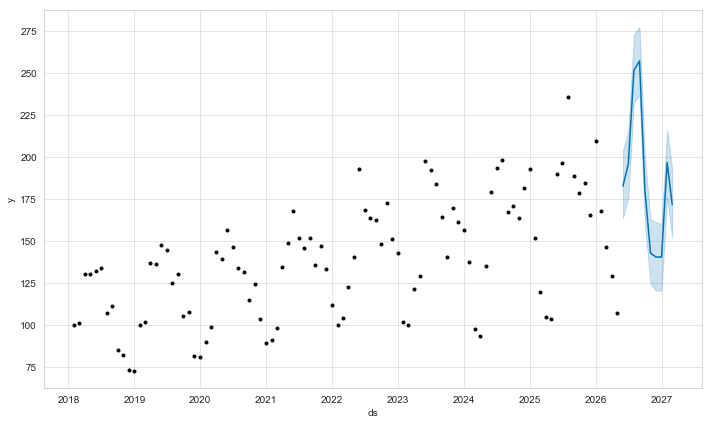

In [22]:
fig1 = model.plot(forecast)

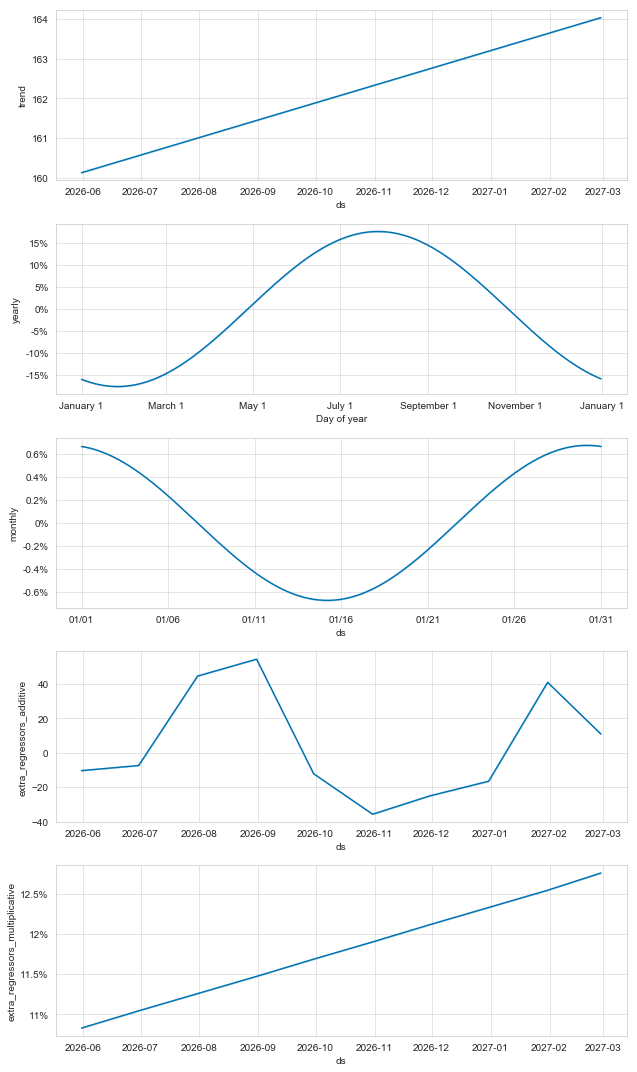

In [23]:
fig2 = model.plot_components(forecast)

## Check model prediction manually 

In [24]:
model.params

{'k': array([[0.18266951]]),
 'm': array([[0.49486902]]),
 'delta': array([[-2.77914628e-10]]),
 'sigma_obs': array([[0.06568005]]),
 'beta': array([[-0.10559719, -0.14162981,  0.00650169,  0.00182467,  0.06221089,
          0.07281766]])}

At first Prophet transforms dataframe to the special format (we use prophet's function) - it just takes initial dataframe and does some transformations and preprocessing: 
- scaling of the target (y_scaled), 
- creates columns "t", that is just scale of time to range \[0, 1\], 
- standartization of exogenous features (subtraction of training mean and division by training variance per feature)

In [25]:
df_train = model.setup_dataframe(data_train_joined_2_regressor)
df_train.head(5)

,y,ds,linear_trend,cyclical_component_1,floor,t,y_scaled
0,100.000000,2018-01-31,-1.706220,0.000321,0,0.000000,0.424294
1,101.157973,2018-02-28,-1.671751,0.024588,0,0.009299,0.429208
2,130.251449,2018-03-31,-1.637282,0.041814,0,0.019595,0.552650
3,129.988055,2018-04-30,-1.602813,-0.022066,0,0.029558,0.551532
4,132.110355,2018-05-31,-1.568344,-0.078205,0,0.039854,0.560537


In [26]:
df_test = model.setup_dataframe(data_test_joined_2_regressor)
df_test.head(5)

,ds,linear_trend,cyclical_component_1,floor,t
0,2026-05-31,1.740690,-0.604014,0,1.010296
1,2026-06-30,1.775159,-0.432429,0,1.020259
2,2026-07-31,1.809628,2.598544,0,1.030555
3,2026-08-31,1.844097,3.170882,0,1.040850
4,2026-09-30,1.878566,-0.708772,0,1.050814


Let's check standartization of the time

In [27]:
# Start of the time
start = data_train_joined_2_regressor["ds"].min()

# Timedelta to the end of training data
t_scale = data_train_joined_2_regressor["ds"].max() - start 

# scaled time to the range [0, 1]
t = ((data_test_joined_2_regressor["ds"] - start) / t_scale).values
print("Standartized time: {0}".format(t))

Standartized time: [1.01029558 1.02025905 1.03055463 1.04085022 1.05081368 1.06110927
 1.07107273 1.08136832 1.0916639  1.10096314]


In [28]:
print("Standartized time by prophet: {0}".format(df_test["t"].values))

Standartized time by prophet: [1.01029558 1.02025905 1.03055463 1.04085022 1.05081368 1.06110927
 1.07107273 1.08136832 1.0916639  1.10096314]


Let's check standartization of the regressors

In [29]:
mu_train = data_train_joined_2_regressor['linear_trend'].mean()
std_train = data_train_joined_2_regressor['linear_trend'].std()

print("Standartized f1 regressor by our calculations: {0}".format(
    ((data_test_joined_2_regressor['linear_trend'] - mu_train) / std_train).values))

Standartized f1 regressor by our calculations: [1.74068952 1.77515862 1.80962772 1.84409682 1.87856592 1.91303502
 1.94750411 1.98197321 2.01644231 2.05091141]


In [30]:
print("Standartized f1 regressor by prophet: {0}".format(df_test["linear_trend"].values))

Standartized f1 regressor by prophet: [1.74068952 1.77515862 1.80962772 1.84409682 1.87856592 1.91303502
 1.94750411 1.98197321 2.01644231 2.05091141]


As we can see we have obtained the same result.

**So, we obtained standartization of features and time, using parameters $\mu$ and $\sigma$ that were calculated using train data.**

Extract the changepoint obtained for standartized time

In [31]:
changepoint_ts = model.changepoints_t
print("Changepoints: {0}".format(changepoint_ts))

Changepoints: [0.79840585]


### Next step is to obtain $k$ and $m$ as initial points for stan optimization

<img src="pngs/trend_k_m.png" width="100%">

In [32]:
# Just extracted the indices of the minimum and maximum
i0, i1 = df_train['ds'].idxmin(), df_train['ds'].idxmax()

# Calculate the time difference for a standardized time
T = df_train['t'].iloc[i1] - df_train['t'].iloc[i0] 

# Calculate k
k = (df_train['y_scaled'].iloc[i1] - df_train['y_scaled'].iloc[i0]) / T

# Calculate m
m = df_train['y_scaled'].iloc[i0] - k * df_train['t'].iloc[i0]

print("initial value for k: {0}".format(k))
print("initial value for m: {0}".format(m))

initial value for k: 0.02954565033653378
initial value for m: 0.42429440852103406


**After stan optimization we will have the following parameters.**

In [33]:
k = np.nanmean(model.params['k'])
m = np.nanmean(model.params['m'])

print("Value for k after stan optimization: {0}".format(k))
print("Value for m after stan optimization: {0}".format(m))

Value for k after stan optimization: 0.18266950869557033
Value for m after stan optimization: 0.494869017108688


### Calculate deltas and gammas

<img src="pngs/trend_gamma_delta.png" width="100%">

In [34]:
deltas = np.nanmean(model.params['delta'], axis = 0)
gammas = -changepoint_ts * deltas

The code below describes how to calculate complete trend component of prediction

<img src="pngs/trend_middle.png" width="100%">

In [35]:
gammas = -changepoint_ts * deltas

k_t = k * np.ones_like(t)
m_t = m * np.ones_like(t)

for s, t_s in enumerate(changepoint_ts):
    indx = t >= t_s
    k_t[indx] += deltas[s]
    m_t[indx] += gammas[s]

trend = k_t * t + m_t

### Destandartization trend component (in our case we have lower bound  - parameter floor - is equal to zero)

<img src="pngs/trend_full.png" width="100%">

In [36]:
floor = 0
trend = trend * model.y_scale + floor

In [37]:
print("Manually calculated trend: {0}".format(trend))

Manually calculated trend: [160.12919359 160.55814614 161.0013971  161.44464807 161.87360061
 162.31685158 162.74580412 163.18905509 163.63230605 164.03266177]


In [38]:
print("Trend calculated by Prophet: {0}".format(forecast.trend.values))

Trend calculated by Prophet: [160.12919359 160.55814614 161.0013971  161.44464807 161.87360061
 162.31685158 162.74580412 163.18905509 163.63230605 164.03266177]


# Multiplicative and additive terms

Next step is to calculate seasonal_components. To do this we will explore prophet functions, that are used to predict seasonal components.

<img src="pngs/multiplicative_terms_new.png" width="100%">

<img src="pngs/additive_terms_new.png" width="100%">

In [39]:
seasonal_components = model.predict_seasonal_components(df_test)
seasonal_components.head()

,additive_terms,additive_terms_lower,additive_terms_upper,cyclical_component_1,cyclical_component_1_lower,cyclical_component_1_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,extra_regressors_multiplicative,...,linear_trend_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper
0,-10.366119,-10.366119,-10.366119,-10.366119,-10.366119,-10.366119,-10.366119,-10.366119,-10.366119,0.108290,...,0.108290,-0.005620,-0.005620,-0.005620,0.204115,0.204115,0.204115,0.101445,0.101445,0.101445
1,-7.421364,-7.421364,-7.421364,-7.421364,-7.421364,-7.421364,-7.421364,-7.421364,-7.421364,0.110434,...,0.110434,-0.005620,-0.005620,-0.005620,0.264446,0.264446,0.264446,0.159632,0.159632,0.159632
2,44.596363,44.596363,44.596363,44.596363,44.596363,44.596363,44.596363,44.596363,44.596363,0.112579,...,0.112579,-0.004718,-0.004718,-0.004718,0.283793,0.283793,0.283793,0.175933,0.175933,0.175933
3,54.418869,54.418869,54.418869,54.418869,54.418869,54.418869,54.418869,54.418869,54.418869,0.114723,...,0.114723,-0.003611,-0.003611,-0.003611,0.254423,0.254423,0.254423,0.143311,0.143311,0.143311
4,-12.163986,-12.163986,-12.163986,-12.163986,-12.163986,-12.163986,-12.163986,-12.163986,-12.163986,0.116867,...,0.116867,-0.003611,-0.003611,-0.003611,0.186869,0.186869,0.186869,0.073613,0.073613,0.073613


In [40]:
seasonal_features, _, component_cols, _ = model.make_all_seasonality_features(df_test)

In [41]:
seasonal_features.head()

,yearly_delim_1,yearly_delim_2,monthly_delim_1,monthly_delim_2,linear_trend,cyclical_component_1
0,0.313107,-0.949718,-0.951057,0.309017,1.740690,-0.604014
1,-0.196673,-0.980469,-0.951057,0.309017,1.775159,-0.432429
2,-0.668064,-0.744104,-0.866025,0.500000,1.809628,2.598544
3,-0.953681,-0.300820,-0.743145,0.669131,1.844097,3.170882
4,-0.977848,0.209315,-0.743145,0.669131,1.878566,-0.708772


In the dataframe seasonal features we have the following data:
- First two columns are responsable for yearly seasonal component, and so we have fourier coefficients in this columns for yearly component. 
- In The 3rd and the 4-th columns fourier coefficient for monthly seasonal component, and finally in the 5-th and the 6-th columns we have just standartized regressors.


**Formulas for calculating coefficients in the columns, that are responsible for seasonal components (this formulas for columns for one seasonal component):**
$$
A[i, j] = [\text{j is even}]*Cos(2 \pi i (j + 1) / period) + [\text{j is odd}]*Sin(2 \pi i (j + 1) / period)
$$

where $i$ is a time index and $j$ is a fourier order for the component

Create t, to calculate fourier series

In [42]:
t = np.array(
    (data_test_joined_2_regressor["ds"] - pd.datetime(1970, 1, 1))
    .dt.total_seconds()
    .astype(np.float)
) / (3600 * 24.)
print("Time in month passed from 01.01.1970 for every test point: {0}".format(t))

Time in month passed from 01.01.1970 for every test point: [20604. 20634. 20665. 20696. 20726. 20757. 20787. 20818. 20849. 20877.]


**Below we calculate the fourier coefficients for yearly seasonal component**

In [43]:
model.seasonalities

{'yearly': {'period': 365,
  'fourier_order': 1,
  'prior_scale': 0.1,
  'mode': 'multiplicative'},
 'monthly': {'period': 30,
  'fourier_order': 1,
  'prior_scale': 0.1,
  'mode': 'multiplicative'}}

<img src="pngs/fourier_new.png" width="50%">

In [44]:
period = model.seasonalities['yearly']["period"]
series_order = model.seasonalities["yearly"]["fourier_order"]

np.column_stack([
    fun((2.0 * (i + 1) * np.pi * t / period))
    for i in range(series_order)
    for fun in (np.sin, np.cos)
])

array([[ 0.31310704, -0.94971784],
       [-0.19667289, -0.98046916],
       [-0.66806386, -0.74410394],
       [-0.953681  , -0.30081981],
       [-0.97784834,  0.20931465],
       [-0.73541702,  0.67761479],
       [-0.30492122,  0.95237758],
       [ 0.22192151,  0.97506453],
       [ 0.68705277,  0.72660752],
       [ 0.94559639,  0.32534208]])

Were obtained the same coefficients (as in seasonal_features) and the regressor is also the same.

### Now we will understand how to obtain the matrix component_cols

In [45]:
component_cols

component,additive_terms,cyclical_component_1,extra_regressors_additive,extra_regressors_multiplicative,linear_trend,monthly,multiplicative_terms,yearly
col,,,,,,,,
0,0,0,0,0,0,0,1,1
1,0,0,0,0,0,0,1,1
2,0,0,0,0,0,1,1,0
3,0,0,0,0,0,1,1,0
4,0,0,0,1,1,0,1,0
5,1,1,1,0,0,0,0,0


It's just a cross-tab matrix that shows for each feature what columns it met in seasonal_matrix + there we  added some special names to distinguish between regressors and not regressors and so on. 

Now we understand how to take into account "additive_terms" and "multiplicative_terms" for the final prediction. Note that these two columns will always be in obtained dataframes for seasonal components, and their sum will always be equal to 1.


In [46]:
# Extract the data
X = seasonal_features.values

# For each seasonal component we calculate
for component in component_cols.columns:
    
    # Here, in fact, we leave the beta non-zero only in those positions where we have 1
    # This is equivalent to the fact that we just made up a mask so that later in the matrix seasonal_features take
    # only the parameters we need
    beta_c = model.params['beta'] * component_cols[component].values
    
    # This is a basic dot product, that is, for each date it's easy
    # multiply the scaled value by the trained beta and add
    # only the parameters that we need
    comp = np.matmul(X, beta_c.transpose())
    
    # If we have additive feature, then we should scale, that is also obvious
    if component in model.component_modes['additive']:
         comp *= model.y_scale
    
    # Exactly this will be in  'multiplicative' and 'additive'
    df_test[component] = np.nanmean(comp, axis=1)

In [47]:
df_test

,ds,linear_trend,cyclical_component_1,floor,t,additive_terms,extra_regressors_additive,extra_regressors_multiplicative,monthly,multiplicative_terms,yearly
0,2026-05-31,0.108290,-10.366119,0,1.010296,-10.366119,-10.366119,0.108290,-0.005620,0.204115,0.101445
1,2026-06-30,0.110434,-7.421364,0,1.020259,-7.421364,-7.421364,0.110434,-0.005620,0.264446,0.159632
2,2026-07-31,0.112579,44.596363,0,1.030555,44.596363,44.596363,0.112579,-0.004718,0.283793,0.175933
3,2026-08-31,0.114723,54.418869,0,1.040850,54.418869,54.418869,0.114723,-0.003611,0.254423,0.143311
4,2026-09-30,0.116867,-12.163986,0,1.050814,-12.163986,-12.163986,0.116867,-0.003611,0.186869,0.073613
5,2026-10-31,0.119012,-35.723865,0,1.061109,-35.723865,-35.723865,0.119012,-0.002345,0.098354,-0.018312
6,2026-11-30,0.121156,-25.088483,0,1.071073,-25.088483,-25.088483,0.121156,-0.002345,0.016124,-0.102686
7,2026-12-31,0.123300,-16.540572,0,1.081368,-16.540572,-16.540572,0.123300,-0.000978,-0.039210,-0.161532
8,2027-01-31,0.125445,40.959380,0,1.091664,40.959380,40.959380,0.125445,0.000433,-0.049582,-0.175460
9,2027-02-28,0.127589,10.895202,0,1.100963,10.895202,10.895202,0.127589,-0.002345,-0.020687,-0.145930


Let us denote by $r_1$, $r_2$ standartized value for regressor $f_1$ anf $f_2$ respectively.
$\phi_{sin_Y}$, $\phi_{cos_Y}$ denotes the fourier coefficient for yearly seasonal component.
$\phi_{sin_M}$, $\phi_{cos_M}$ denotes the fourier coefficient for monthly seasonal component.

- **Then the multiplicative term in this case will be just $\phi_{sin_Y} * \beta_{0} + \phi_{cos_Y} * \beta_{1}$ + $\phi_{sin_M} * \beta_{2} + \phi_{cos_M} * \beta_{3} + r_1 * \beta_4$**

- **And additive will be $r_2 \beta_5$**

Let's check this:

<img src="pngs/additive_product_new.png" width="100%">

In [48]:
additive_terms = model.params["beta"].squeeze()[5] * seasonal_features["cyclical_component_1"] * model.y_scale
print("Manually calculated additive terms: {0}".format(additive_terms.values))

Manually calculated additive terms: [-10.3661191   -7.42136404  44.5963631   54.41886891 -12.16398556
 -35.72386514 -25.08848321 -16.54057207  40.95937968  10.89520213]


In [49]:
print("Additive terms calculated by Prophet: {0}".format(
    seasonal_components["additive_terms"].values))

Additive terms calculated by Prophet: [-10.3661191   -7.42136404  44.5963631   54.41886891 -12.16398556
 -35.72386514 -25.08848321 -16.54057207  40.95937968  10.89520213]


**We have obtained the same additive terms**

<img src="pngs/multiplicative_product_new.png" width="100%">

In [50]:
multiplicative_terms = (model.params["beta"].squeeze()[0] * seasonal_features["yearly_delim_1"] + 
        model.params["beta"].squeeze()[1] * seasonal_features["yearly_delim_2"] + 
        model.params["beta"].squeeze()[2] * seasonal_features["monthly_delim_1"] + 
        model.params["beta"].squeeze()[3] * seasonal_features["monthly_delim_2"] + 
        model.params["beta"].squeeze()[4] * seasonal_features["linear_trend"])
print("Manually calculated multiplicative terms: {0}".format(multiplicative_terms.values))

Manually calculated multiplicative terms: [ 0.20411537  0.26444636  0.28379324  0.25442325  0.18686936  0.09835373
  0.01612433 -0.03920973 -0.04958243 -0.02068684]


In [51]:
print("Multiplicative terms calculated by Prophet: {0}".format(
    seasonal_components["multiplicative_terms"].values))

Multiplicative terms calculated by Prophet: [ 0.20411537  0.26444636  0.28379324  0.25442325  0.18686936  0.09835373
  0.01612433 -0.03920973 -0.04958243 -0.02068684]


**Additive и multiplicative are the same. So, the final prediction is:**

## Final prediction

<img src="pngs/final_product.png" width="100%">

In [52]:
prediction = trend * (1 + multiplicative_terms) + additive_terms
print("Manually calculated prediction: {0}".format(prediction.values))

Manually calculated prediction: [182.44790435 195.59579911 251.28886828 256.93878901 179.95883105
 142.55745415 140.28148841 140.24988493 196.47839811 171.53454719]


In [53]:
forecast = model.predict(data_test_joined_2_regressor)
print("Prediction calculated by Prophet: {0}".format(forecast["yhat"].values))

Prediction calculated by Prophet: [182.44790435 195.59579911 251.28886828 256.93878901 179.95883105
 142.55745415 140.28148841 140.24988493 196.47839811 171.53454719]


**As we can see our manual prediction by Prophet completely formula coincides with Prophet model output!**